# Data post-processing and analysis

Once the models are trained, we will try to predict the data we have. We will do some final processing on the outputs and finally evaluate the whole result so we can get a better idea of the models final performance. 

In [29]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns 

## Data prediction

We will start by loading our trained models and processing one video to get their outputs. We will load and process each video in a time, so we don't get memory problems.

### Load data

In [30]:
# Load video and its corresponding csv
path_validation =  '../data/validation/'
path_raw_data = '../data/raw/csvs/'
vname = 'HD_ChR2_510A'
video = '510A.mp4'

# For now we wil just process one video 
df_csv = pd.read_csv(os.path.join(path_raw_data, vname +'.csv'), header=0)
labels = pd.read_csv(os.path.join(path_validation, vname +'.csv'), header=0)
if 'rearing_mig' and 'rearing_paret' in labels.columns:
    labels["rearing"] = np.max(labels[['rearing_mig', 'rearing_paret']], axis=1)
    #labels = labels.drop(['rearing_mig', 'rearing_paret'], axis=1)
df_csv.head()

,frame_seq,Genotip,Tractament,Estimulació,Grooming,Rearing mig,Rearing paret,snout x,snout y,snout likelihood,...,NBackR x,NBackR y,NBBackR x,NBBackR y,NBmidbody x,NBmidbody y,EFrontL likelihood,EFrontR likelihood,EBackL likelihood,EBackR likelihood
0,0,0,0,0,0,0,0,264.483795,282.601379,0.998579,...,-28.784378,-13.843079,173.702702,186.983551,202.487080,200.826630,1.0,0.0,1.0,1.0
1,1,0,0,0,0,0,0,264.753876,283.208466,0.999337,...,-28.939362,-13.849136,173.184772,186.693474,202.124134,200.542610,1.0,1.0,1.0,1.0
2,2,0,0,0,0,0,0,265.712921,282.768890,0.999493,...,-29.033600,-14.043655,173.388065,186.377792,202.421665,200.421448,1.0,1.0,1.0,1.0
3,3,0,0,0,0,0,0,264.992767,281.504517,0.998960,...,-28.755707,-14.065781,173.316635,186.521915,202.072342,200.587696,1.0,1.0,1.0,1.0
4,4,0,0,0,0,0,0,259.602142,280.463470,0.999667,...,-29.405029,-14.450851,173.366657,186.833748,202.771687,201.284599,1.0,1.0,1.0,1.0


In [31]:
labels[(labels['rearing_paret'] == 1) & (labels['rearing'] != 1)]

,grooming,rearing_mig,rearing_paret,rearing


In [32]:
labels.head()

,grooming,rearing_mig,rearing_paret,rearing
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


## LSTM Models results

We will create a dataframe where we will save all the predictions and the true labels, so later we can compare them and get some performance evaluation.

In [33]:
results = labels.copy()
labels

,grooming,rearing_mig,rearing_paret,rearing
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
6595,0,0,0,0
6596,0,0,0,0
6597,0,0,0,0
6598,0,0,0,0


### Models prediction 

In [34]:
# Behaviours we want to evaluate
behaviours = ["grooming", "rearing"]

#### Upload data already processed by ResNet

In [35]:
features =  np.load(path_validation + vname + '.npy')
features

array([[1.3980776e-01, 1.3035992e+00, 3.1568565e-05, ..., 1.1767397e+00,
        1.9021536e-01, 4.7149796e+00],
       [3.0432385e-01, 1.4267254e+00, 1.1755615e-01, ..., 1.1160787e+00,
        7.6400834e-01, 4.0728264e+00],
       [2.7317542e-01, 1.5951252e+00, 3.1677943e-03, ..., 1.1577787e+00,
        3.7884015e-01, 4.2296453e+00],
       ...,
       [1.5315411e+00, 8.1364691e-01, 3.9197970e-02, ..., 1.1689570e-01,
        4.8727670e-01, 5.4834370e-02],
       [1.7698689e+00, 1.5022445e-01, 7.5868089e-03, ..., 2.1694420e-01,
        3.9630932e-01, 1.9168440e-01],
       [3.2084489e-01, 7.8572720e-01, 1.8976864e-01, ..., 2.2723505e-01,
        1.2577452e-01, 7.4052358e-01]], dtype=float32)

In [159]:
%%time 
    
# Lists where the results will be stored
grooming = []
rearing = []

# Predict data in batches so it consumes less memory and less time 
for i in range(0, len(features), 300):
    print('Batch ', i)
    # Extract features from that batch 
    f = features[i: i + 300]
    f2 = np.zeros((1, 300, 2048))
    f2[0] = f
    
    for b in behaviours: 
        print("Behaviour ", b)
        # Get the result for each wanted behaviour
        if b == "grooming":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_grooming.h5')
            grooming.append(model.predict(f2))
        elif b == "rearing":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_rearing.h5')
            rearing.append(model.predict(f2))
        
# Add results to dataframe
if "grooming" in behaviours:
    results['g_prediction'] = list(np.concatenate(grooming[:]).flat)
if "rearing" in behaviours:
    results['r_prediction'] = list(np.concatenate(rearing[:]).flat)

Batch  0
Behaviour  grooming
1/1 [==============================] - 1s 522ms/step
Behaviour  rearing
1/1 [==============================] - 0s 442ms/step
Batch  300
Behaviour  grooming
1/1 [==============================] - 0s 398ms/step
Behaviour  rearing
1/1 [==============================] - 0s 395ms/step
Batch  600
Behaviour  grooming
1/1 [==============================] - 0s 418ms/step
Behaviour  rearing
1/1 [==============================] - 0s 416ms/step
Batch  900
Behaviour  grooming
1/1 [==============================] - 0s 390ms/step
Behaviour  rearing
1/1 [==============================] - 0s 395ms/step
Batch  1200
Behaviour  grooming
1/1 [==============================] - 0s 468ms/step
Behaviour  rearing
1/1 [==============================] - 0s 414ms/step
Batch  1500
Behaviour  grooming
1/1 [==============================] - 0s 422ms/step
Behaviour  rearing
1/1 [==============================] - 0s 398ms/step
Batch  1800
Behaviour  grooming
1/1 [===========================

TypeError: 'list' object is not callable

In [160]:
results.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,grooming,rearing_mig,rearing_paret,rearing,g_prediction,r_prediction,g_result,r_result
0,0,0,0,0,0,0,0,0,0,0.118793,0.295803,0,0
1,1,1,1,1,1,0,0,0,0,0.009604,0.078821,0,0
2,2,2,2,2,2,0,0,0,0,0.002003,0.014070,0,0
3,3,3,3,3,3,0,0,0,0,0.000997,0.003413,0,0
4,4,4,4,4,4,0,0,0,0,0.000749,0.001518,0,0


#### Save results

In [161]:
# We can save our results so we can continue working with them later
results.to_csv(path_validation + 'results2.csv')

## Data post-processing

After obtaining our predictions we will analyze and process them, enough to get the best result. 

In [162]:
results = pd.read_csv(path_validation + 'results2.csv')

### Output visualization

We will start by plotting some graphics that will allow us to understand the natures of the predictions. We will be able to compare them with the real values in a visual, so we can easily see at a first glance how worng or correct they were. In addition, this will give us some insights on how prediction action sequences work, may they follow some kind of ditribution. 

grooming


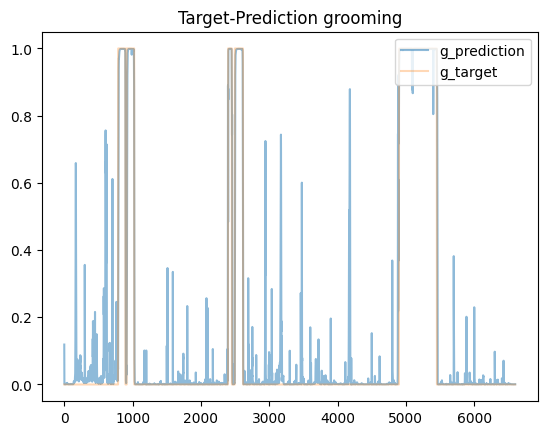

rearing


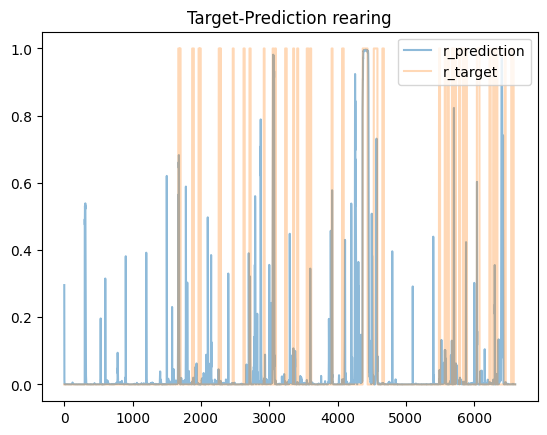

In [163]:
# Let's plot some double histograms for each behaviour
for b in behaviours: 
    print(b)
    if b == "grooming":
        plt.plot(results['g_prediction'],  
        alpha=0.5,
        label='g_prediction') 
        plt.plot(results['grooming'],  
        alpha=0.3,
        label='g_target') 
        plt.legend(loc='upper right') 
        plt.title('Target-Prediction grooming') 
        plt.show()
    elif b == "rearing":
        plt.plot(results['r_prediction'],  
        alpha=0.5,
        label='r_prediction') 
        plt.plot(results['rearing'],  
        alpha=0.3,
        label='r_target') 
        plt.legend(loc='upper right') 
        plt.title('Target-Prediction rearing') 
        plt.show()


At a first glance, it seems that 0.8 would work well as a threshold for all the 3 classes, eventhought, we will plot some more stadistics to make sure. 

In [170]:
print(results.groupby('grooming')['g_prediction'].describe())
print(results.groupby('rearing')['r_prediction'].describe())

           count      mean       std       min       25%       50%       75%  \
grooming                                                                       
0         5652.0  0.021815  0.093090  0.000482  0.000753  0.001300  0.005263   
1          948.0  0.979759  0.095882  0.122621  0.998152  0.998645  0.998761   

               max  
grooming            
0         0.976344  
1         0.998837  
          count      mean       std       min       25%       50%       75%  \
rearing                                                                       
0        5754.0  0.021520  0.102806  0.000388  0.000601  0.000944  0.002846   
1         846.0  0.133727  0.305241  0.000404  0.000826  0.002502  0.021773   

              max  
rearing            
0        0.993317  
1        0.996437  


We can experiment by setting 2 different thresholds, 0.5 and 0.8, and see which one gives us better results. 

### Setting thresholds and argmax

We will transalte the predictions results in 0's and 1's. For that, we will define our 2 different thresholds and an argmax.

##### Threshold = 0.5

In [171]:
thershold = 0.5
results05 = results.copy()

results05['g_result'] = results05['g_prediction']
results05['r_result'] = results05['r_prediction']

# If value lower than 0.5, write 0 
results05.loc[results05['g_prediction'] < thershold,'g_result'] = 0
results05.loc[results05['r_prediction'] < thershold,'r_result'] = 0

for ind,row in results05.iterrows():
    # Get the only columns we want to use
    row2 = row[['g_result', 'r_result']]
    if max(row2) != 0:
        action = np.argmax(row2) # Get index column with max value
        if action == 0:
            row['g_result'] = 1
            row['r_result'] = 0
            results05.iloc[ind] = row
        elif action == 1:
            row['r_result'] = 1
            row['g_result'] = 0
            results05.iloc[ind] = row

In [172]:
results05

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,grooming,rearing_mig,rearing_paret,rearing,g_prediction,r_prediction,g_result,r_result
0,0,0,0,0,0,0,0,0,0,0,0.118793,0.295803,0.0,0.0
1,1,1,1,1,1,1,0,0,0,0,0.009604,0.078821,0.0,0.0
2,2,2,2,2,2,2,0,0,0,0,0.002003,0.014070,0.0,0.0
3,3,3,3,3,3,3,0,0,0,0,0.000997,0.003413,0.0,0.0
4,4,4,4,4,4,4,0,0,0,0,0.000749,0.001518,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,6595,6595,6595,6595,6595,0,0,0,0,0.000595,0.000556,0.0,0.0
6596,6596,6596,6596,6596,6596,6596,0,0,0,0,0.000671,0.000518,0.0,0.0
6597,6597,6597,6597,6597,6597,6597,0,0,0,0,0.000741,0.000465,0.0,0.0
6598,6598,6598,6598,6598,6598,6598,0,0,0,0,0.000768,0.000451,0.0,0.0


##### Threshold = 0.9

In [173]:
thershold = 0.9
results08 = results.copy()

results08['g_result'] = results05['g_prediction']
results08['r_result'] = results05['r_prediction']

# If value lower than 0.5, write 0 
results08.loc[results08['g_prediction'] < thershold,'g_result'] = 0
results08.loc[results08['r_prediction'] < thershold,'r_result'] = 0

for ind,row in results08.iterrows():
    # Get the only columns we want to use
    row2 = row[['g_result', 'r_result']]
    if max(row2) != 0:
        action = np.argmax(row2) # Get index column with max value
        if action == 0:
            row['g_result'] = 1
            row['r_result'] = 0
            results08.iloc[ind] = row
        elif action == 1:
            row['r_result'] = 1
            row['g_result'] = 0
            results08.iloc[ind] = row

In [174]:
results08

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,grooming,rearing_mig,rearing_paret,rearing,g_prediction,r_prediction,g_result,r_result
0,0,0,0,0,0,0,0,0,0,0,0.118793,0.295803,0.0,0.0
1,1,1,1,1,1,1,0,0,0,0,0.009604,0.078821,0.0,0.0
2,2,2,2,2,2,2,0,0,0,0,0.002003,0.014070,0.0,0.0
3,3,3,3,3,3,3,0,0,0,0,0.000997,0.003413,0.0,0.0
4,4,4,4,4,4,4,0,0,0,0,0.000749,0.001518,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,6595,6595,6595,6595,6595,0,0,0,0,0.000595,0.000556,0.0,0.0
6596,6596,6596,6596,6596,6596,6596,0,0,0,0,0.000671,0.000518,0.0,0.0
6597,6597,6597,6597,6597,6597,6597,0,0,0,0,0.000741,0.000465,0.0,0.0
6598,6598,6598,6598,6598,6598,6598,0,0,0,0,0.000768,0.000451,0.0,0.0


### Evaluating models

Now that we have results for both thersholds, let's see which gave better results.

In [175]:
evaulation = pd. DataFrame(0.0, index=np.arange(len(results)), columns=['rmse05', 'rmse08','rmse_result'])
evaulation.head()

,rmse05,rmse08,rmse_result
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [176]:
# We can start by evaluating the RMSE of the predicted results and the real ones.
from sklearn.metrics import mean_squared_error

for ind,row in results05.iterrows():
    evaulation.iloc[ind]['rmse05'] = mean_squared_error(results05[['grooming', 'rearing']].iloc[ind], results05[['g_result','r_result']].iloc[ind], squared=True)
    evaulation.iloc[ind]['rmse08'] = mean_squared_error(results08[['grooming', 'rearing']].iloc[ind], results08[['g_result','r_result']].iloc[ind], squared=True)

In [177]:
evaulation['rmse05'].unique()

array([0. , 0.5])

In [178]:
evaulation['rmse08'].unique()

array([0. , 0.5])

In [179]:
print('Threshold 05:  Correct = ', len(evaulation[evaulation['rmse05'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse05'] == 0]))
print('Threshold 08:  Correct = ', len(evaulation[evaulation['rmse08'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse08'] == 0]))

Threshold 05:  Correct =  5686 , Incorrect =  914
Threshold 08:  Correct =  5756 , Incorrect =  844


Threshold 0.8 works better.

In [180]:
results[['g_result','r_result']] = results05[['g_result','r_result']]
results

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,grooming,rearing_mig,rearing_paret,rearing,g_prediction,r_prediction,g_result,r_result
0,0,0,0,0,0,0,0,0,0,0,0.118793,0.295803,0.0,0.0
1,1,1,1,1,1,1,0,0,0,0,0.009604,0.078821,0.0,0.0
2,2,2,2,2,2,2,0,0,0,0,0.002003,0.014070,0.0,0.0
3,3,3,3,3,3,3,0,0,0,0,0.000997,0.003413,0.0,0.0
4,4,4,4,4,4,4,0,0,0,0,0.000749,0.001518,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,6595,6595,6595,6595,6595,0,0,0,0,0.000595,0.000556,0.0,0.0
6596,6596,6596,6596,6596,6596,6596,0,0,0,0,0.000671,0.000518,0.0,0.0
6597,6597,6597,6597,6597,6597,6597,0,0,0,0,0.000741,0.000465,0.0,0.0
6598,6598,6598,6598,6598,6598,6598,0,0,0,0,0.000768,0.000451,0.0,0.0


### Squence evaulation and treatment 

We will also evaluate how behaviour sequences work and treat them enough to improve the result.

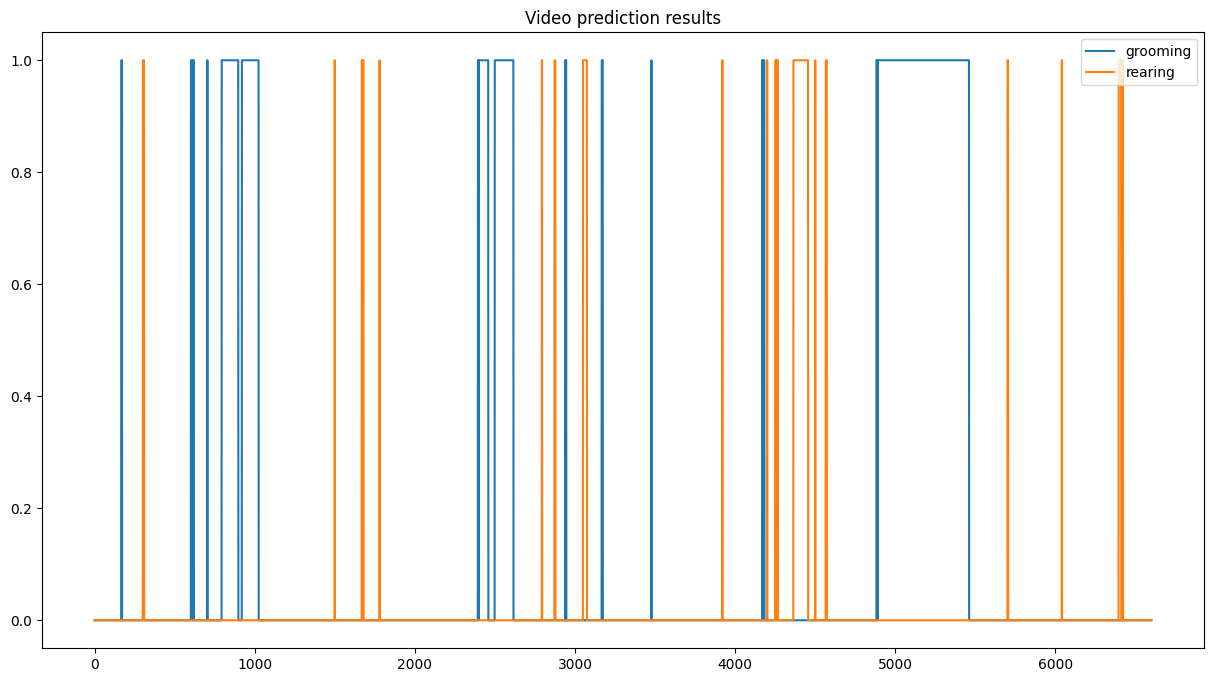

In [181]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(results[['g_result','r_result']],  
        label=['grooming', 'rearing']) 
plt.title('Video prediction results') 
plt.legend(loc='upper right') 
plt.show()

We are going to try to find sequences with very few layers and clean them.

In [182]:
list = []
for i in range(5):
    list += [1]

list

[1, 1, 1, 1, 1]

In [183]:
# Process grooming
def process_sequences_grooming(binary_array):
    result = []
    current_ones_subsequence = []
    
    for digit in binary_array:
        if digit == 1:
            current_ones_subsequence += [1]
        elif current_ones_subsequence:
            if len(current_ones_subsequence) < 20:
                result += [0]*(len(current_ones_subsequence) + 1)
                current_ones_subsequence = []
            else:
                result += current_ones_subsequence
                result += [0]
                current_ones_subsequence = []
        else: 
             result += [0]
            
    return result
    
# Process grooming
def process_sequences_rearing(binary_array):
    result = []
    current_ones_subsequence = []
    
    for digit in binary_array:
        if digit == 1:
            current_ones_subsequence += [1]
        elif current_ones_subsequence:
            if len(current_ones_subsequence) < 20:
                result += [0]*(len(current_ones_subsequence) + 1)
                current_ones_subsequence = []
            else:
                result += current_ones_subsequence
                result += [0]
                current_ones_subsequence = []
        else: 
             result += [0]
            
    return result

In [184]:
results['g_result'] = process_sequences_grooming(results['g_result'])
results['r_result'] = process_sequences_rearing(results['r_result'])

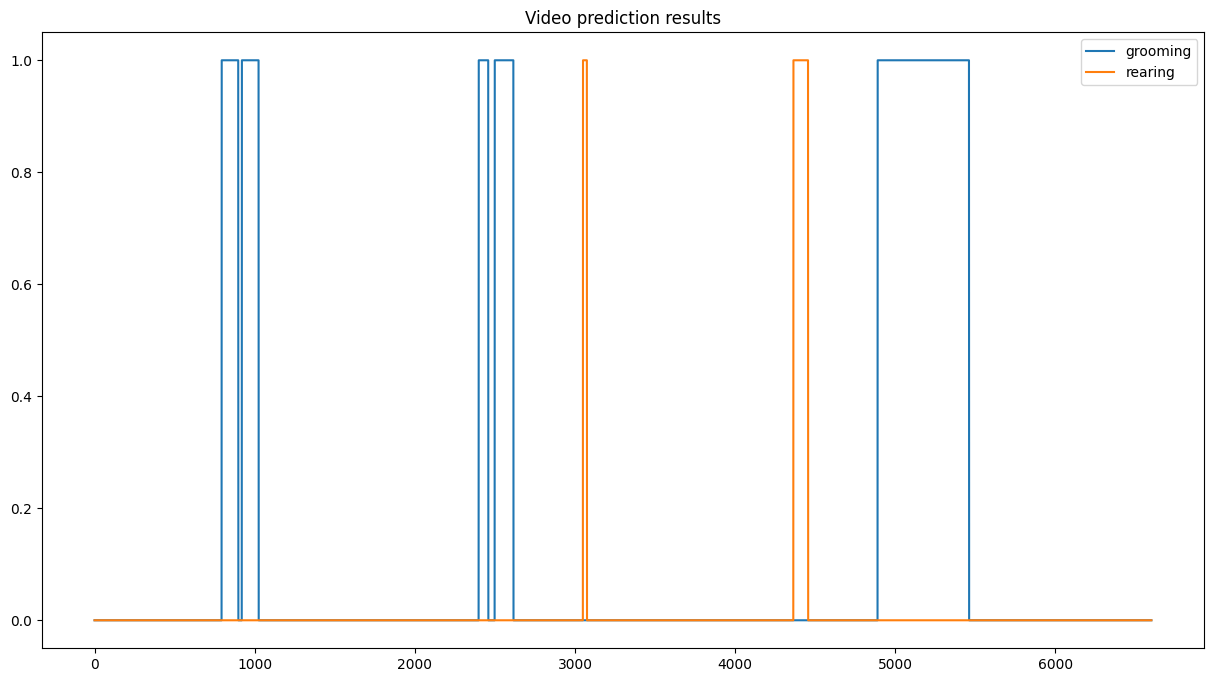

In [185]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(results[['g_result','r_result']],  
        label=['grooming', 'rearing']) 
plt.title('Video prediction results') 
plt.legend(loc='upper right') 
plt.show()

In [186]:
# We can start by evaluating the RMSE of the predicted results and the real ones.
from sklearn.metrics import mean_squared_error

for ind,row in results05.iterrows():
    evaulation.iloc[ind]['rmse08'] = mean_squared_error(results[['grooming', 'rearing']].iloc[ind], results[['g_result','r_result']].iloc[ind], squared=True)

In [187]:
print('Threshold 08:  Correct = ', len(evaulation[evaulation['rmse08'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse08'] == 0]))

Threshold 08:  Correct =  5766 , Incorrect =  834
